# Wreckognition

In this section, we will see a few examples of:
* geographic tools
* using numpy to manipulate images
* applying image filters
* segmentation
* ML-style clustering

We will use DAERA's list of protected shipwrecks, hosted by OpenDataNI. For more information, see the [page on their site](https://www.opendatani.gov.uk/dataset/protected-wreck-sites).

Using these tools, we hope to answer the questions:

> Do wrecks cluster near groups of ports?

and

> Are wrecks more common in deep water or shallow water?

We may even try to see whether shipwrecks in the 1800s, 1900s or 2000s have different likely locations.

To begin, we will open up the downloaded dataset using geopandas - this is an extended version of pandas that can attach geographic (or geometric) attributes to each row.

## Geopandas

In [1]:
import geopandas as gpd

In [2]:
gdf = gpd.read_file('data/protected_wrecks.geojson')

In [3]:
gdf

,Name,Date_lost,Type,Cargo,Depth,Position_q,Condition,Ref,Status,Notes,...,X_Coord,Y_Coord,Updated,Nation,How_lost,Legislatio,Notes_1,Origin,Where_lost,geometry
0,Ailsa,26/02/1892,Steamship (British),General,1-5m,Reasonable,"Badly broken up, part of wreck is onshore","UKHO, IRW, CMA",LIVE,None,...,-5.738217,54.852500,None,None,None,None,None,None,None,POINT (-5.738216765202008 54.85250042372012)
1,(ex HMS) Alastor,11/03/1946,Corvette / Motor yacht (British),None,10-23m,Accurate,Llargely intact with upright funnel. Wooden de...,"UKHO, IRW, CMA",LIVE,None,...,-5.629383,54.451550,None,None,None,None,None,None,None,POINT (-5.629383430791251 54.45155042371992)
2,Albia (poss.),28/09/1929,Spanish tramp steamer,Copper ore,10m,Approximate,"5m high, upright.","IRW, UKHO, CMA",LIVE,None,...,-5.741317,54.949933,None,None,None,None,None,None,None,POINT (-5.741317099083887 54.94993342278837)
3,Alcedo,??/01/1892,Steam coaster,Coal,7m,Approximate,"2.5m high, badly broken up","IRW, CMA",LIVE,None,...,-5.696200,54.815483,None,None,None,None,None,None,None,POINT (-5.696200098805885 54.81548342367984)
4,Alder,None,None,None,-3m,Approximate,None,UKHO,LIFT,Wreck removed 1938,...,-6.098500,54.053217,None,None,None,None,None,None,None,POINT (-6.098500100507256 54.05321709066201)
5,Alliance,12/02/1997,Motor trawler (British),None,31m,Accurate,Wreck with wooden hull,UKHO,LIVE,None,...,-5.818667,54.020167,None,None,None,None,None,None,None,POINT (-5.818666764178041 54.02016709118345)
6,Amber,02/05/1917,Steamship (British),Coal,46-35m,Reasonable,"7m high, in one piece","UKHO, IRW, CMA",LIVE,None,...,-5.386333,54.474333,None,None,None,None,None,None,None,POINT (-5.38633342867518 54.47433375774758)
7,Andania (prob.),27/01/1918,Passenger ship (British),General,175m,Accurate,Intact. Anomaly = 160 X 39 X 13.3m,"UKHO, CMA",LIVE,None,...,-6.213450,55.325883,None,None,None,None,None,None,None,POINT (-6.213450104169857 55.32588375530833)
8,Annagher,11/12/1937,Steamship (British),Scrap iron+steel,15-7m,Accurate,Scattered wreckage,"UKHO, IRW, CMA",LIVE,Clearly visible RN/AFBI multibeam,...,-5.630483,54.683417,None,None,None,None,None,None,None,POINT (-5.630483430819159 54.68341709025423)
9,Arantzazu Mendi,09/05/1939,Steamship (Spanish),Iron ore,5m,Reasonable,"10m high, broken into sections. Scattered plates","UKHO, IRW, CMA",LIVE,None,...,-5.441617,54.374333,None,None,None,None,None,None,None,POINT (-5.441616761483558 54.37433375806866)


Exploring this data, we see a range of ships - also a few data quality issues in the dates and missing values.

If you have a look at the last, "geometry", column, you will see an entity in WKT (well-known text) format - a computer-readable way of specifying entities.

We can use matplotlib to take a look.

In [4]:
%matplotlib inline

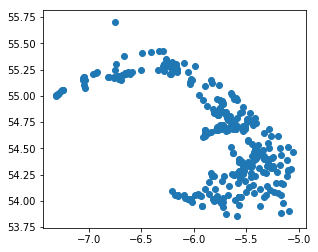

In [5]:
gdf.plot()

## What? That's not a map

OK, so that's a scatterplot, which isn't much of a map. We have seen how Python allows us to easily combine different tools and modes of expression. We can use a package called `folium` to make OpenStreetMap / Google Maps style interactive maps.

In [6]:
import folium

Naturally, before we show a useful map, we need to decide how to centre it somewhere relevant.

As it happens, the point associated with each row in geopandas is a `Shapely` geometric entity. It could also be a line, polygon, circle, or a combination of those, for example. We can also ask for the `gdf.geometry`, which is the collection of all the row entities.

Shapely is a geometric package - this means we can do geometric operations on the rows. For example, we can combine all the points into one polka-dot geometric entity - a union operation.

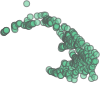

In [7]:
gdf.geometry.unary_union

As a 2d geometric entity, it also has a centroid - a weighted midpoint - which will suffice for us to centre our map.

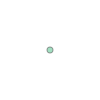

In [8]:
middle = gdf.geometry.unary_union.centroid
middle

Geometric manipulation is much more useful than mapping - it is critical in many forms of numerical analysis, engineering, design and 3d printing. Explore Shapely's toolkit at your leisure.

## Map time

In [9]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

def add(wreck):
    pt = wreck.geometry
    folium.Marker(
        [pt.y, pt.x],
        popup=wreck['Name'],
    ).add_to(fmap)
    return wreck

gdf = gdf.apply(add, axis=1)
fmap

That should be familiar - as previously, we use the `apply` method on a dataframe to iterate through it (a geopandas geodataframe, but it's essentially the same idea). In each step, we add a marker to the map.

In the first line, we create a map, setting the centre and zoom. For each wreck, we add its coordinates to a new folium `Marker` and call the `add_to` method to append it to the map.

## Exercise

Can you write a function that will take a string entry (it will be the content of the Date_Lost column) and return a string representing the century - '18', '19' or '20' - or None if it is not one of those? 

CLUE: `dateutil` has a parser that can make a best guess at which date a string represents: `dateutil.parser.parse(dt)`

In [ ]:
import dateutil

def get_century(dt):
    date = None
    
    ...

    return date

Now we can add a `century` column to the data.

In [22]:
def add(wreck):
    wreck['century'] = get_century(wreck['Date_lost'])
    return wreck

gdf = gdf.apply(add, axis=1)
gdf.head()

,Name,Date_lost,Type,Cargo,Depth,Position_q,Condition,Ref,Status,Notes,...,Updated,Nation,How_lost,Legislatio,Notes_1,Origin,Where_lost,geometry,century,label
0,Ailsa,26/02/1892,Steamship (British),General,1-5m,Reasonable,"Badly broken up, part of wreck is onshore","UKHO, IRW, CMA",LIVE,None,...,None,None,None,None,None,None,None,POINT (-5.738216765202008 54.85250042372012),18,-1
1,(ex HMS) Alastor,11/03/1946,Corvette / Motor yacht (British),None,10-23m,Accurate,Llargely intact with upright funnel. Wooden de...,"UKHO, IRW, CMA",LIVE,None,...,None,None,None,None,None,None,None,POINT (-5.629383430791251 54.45155042371992),19,-1
2,Albia (poss.),28/09/1929,Spanish tramp steamer,Copper ore,10m,Approximate,"5m high, upright.","IRW, UKHO, CMA",LIVE,None,...,None,None,None,None,None,None,None,POINT (-5.741317099083887 54.94993342278837),19,-1
3,Alcedo,??/01/1892,Steam coaster,Coal,7m,Approximate,"2.5m high, badly broken up","IRW, CMA",LIVE,None,...,None,None,None,None,None,None,None,POINT (-5.696200098805885 54.81548342367984),None,-1
4,Alder,None,None,None,-3m,Approximate,None,UKHO,LIFT,Wreck removed 1938,...,None,None,None,None,None,None,None,POINT (-6.098500100507256 54.05321709066201),None,-1


Many points don't have a century, but lets ignore that for now.

Folium also lets us group markers. This is much more useful. Here we create several `FeatureGroup` map layers and them to the map. We then add markers directly to each century's FeatureGroup with coloured icons. At the end, we add a layer control, so you can turn each group on and off.

In [23]:
from folium import FeatureGroup, LayerControl

fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

centuries = {
    '18': 'red',
    '19': 'green',
    '20': 'blue'
}
clusters = {}

for century, colour in centuries.items():
    clusters[century] = FeatureGroup(name=century)
    clusters[century].add_to(fmap)

def add(wreck):
    wreck['century'] = get_century(wreck['Date_lost'])
    
    pt = wreck.geometry
    if wreck['century'] in centuries:
        colour = centuries[wreck['century']]
        folium.Marker(
            [pt.y, pt.x],
            popup=wreck['Name'],
            icon=folium.Icon(color=colour)
        ).add_to(clusters[wreck['century']])
        
    return wreck

gdf = gdf.apply(add, axis=1)

LayerControl().add_to(fmap)
fmap

## Changing of the Seasons

Let's pick a century. 1900's, for example.

In [28]:
century = '18' # if you want to try a different century, come back here, change this and run the cells below

In [34]:
# kmeans isn't the best option, as lat-long is not linear and we are guessing cluster numbers,
# but this illustrates how it can work
from sklearn.cluster import KMeans
import numpy as np

gdf['label'] = -1
kdf = gdf[gdf['century'] == century]
locations = np.array([[w.geometry.y, w.geometry.x] for n, w in kdf.iterrows()])
locations

array([[54.85250042, -5.73821677],
       [54.44620042, -5.37560009],
       [54.85368342, -5.7697831 ],
       [54.78753342, -5.6885831 ],
       [54.67150913, -5.77305105],
       [55.27499802, -6.2025764 ],
       [54.33125416, -5.49898497],
       [54.06666709, -5.95833343],
       [54.85222589, -5.7908119 ],
       [55.29536126, -6.28592233],
       [54.43380042, -5.39493309],
       [55.26420184, -6.19813141],
       [54.58333342, -5.4833331 ],
       [55.27752641, -6.17896666],
       [54.53983376, -5.45181565],
       [54.95288342, -5.7302501 ],
       [54.38882984, -5.56496278],
       [55.19286713, -6.70915706],
       [54.88200042, -5.75271677],
       [54.95286742, -5.7302501 ],
       [54.69685785, -5.5302748 ],
       [55.14917541, -6.02282832],
       [55.29163042, -6.2468801 ],
       [55.20695042, -6.60878344],
       [54.66873119, -5.52915254],
       [53.95381709, -5.92096677],
       [55.16916709, -6.75961678],
       [54.88255042, -5.75188343]])

Now we set up our k-means algorithm - this involves choosing an expected number of clusters - and fit it to our locations list. It generates a numpy array of labels, one entry for each location representing its cluster.

In [30]:
kmeans = KMeans(n_clusters=6).fit(locations)
kmeans.labels_

array([4, 5, 4, 4, 4, 1, 5, 2, 4, 1, 5, 1, 0, 1, 0, 4, 5, 3, 4, 4, 0, 1,
       1, 3, 0, 2, 3, 4], dtype=int32)

We can then add these in the specific entries in the dataframe.

In [35]:
for n, label in enumerate(kmeans.labels_):
    gdf.loc[kdf.index[n], 'label'] = label

kdf = gdf[gdf['century'] == century]
kdf.loc[:, 'label'].head()

0     4
10    5
18    4
22    4
29    4
Name: label, dtype: int64

How does this look on the original map?

In [36]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

colours = ['red', 'green', 'blue', 'orange', 'pink', 'gray']
clusters = {}

for label, colour in enumerate(colours):
    clusters[label] = FeatureGroup(name="Cluster %d" % label)
    clusters[label].add_to(fmap)

def add(wreck):  
    pt = wreck.geometry
    
    colour = colours[wreck['label']]
    folium.Marker(
        [pt.y, pt.x],
        popup=wreck['Name'],
        icon=folium.Icon(color=colour)
    ).add_to(clusters[wreck['label']])
    
    return wreck

kdf = kdf.apply(add, axis=1)

LayerControl().add_to(fmap)
fmap

# Quiz

* Which of NI's main harbours match to which clusters?
* How does it change with the number of labels you use?
* How does it change with the century?

# Looks deep

Next question: is there a correlation between depth and number of shipwrecks?

Rather than using the official bathymetry data, we will try and guess depth from shades of blue in satellite images. There's a few issues with our approach here - such as the resolution of the images, the processing that's already been done to them, the fact that colour isn't necessarily a good proxy for depth - but it will demonstrate how we can use image manipulation to back up other analysis.

First, we show the Sentinel-2 open satellite data as a map layer.

In [37]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

attr = """
<i>
<a class="a-light" xmlns:dct="http://purl.org/dc/terms/"
      href="https://s2maps.eu" property="dct:title">
  Sentinel-2 cloudless - https://s2maps.eu
</a> by
<a class="a-light" xmlns:cc="http://creativecommons.org/ns#"
      href="https://eox.at" property="cc:attributionName"
      rel="cc:attributionURL">
  EOX IT Services GmbH
</a><br/>
(Contains modified Copernicus Sentinel data 2016 &amp; 2017)</i>
"""
sentinel = folium.WmsTileLayer(
    url='https://tiles.maps.eox.at/wms',
    name='s2maps.eu',
    fmt='image/png',
    attr=attr,
    layers='s2cloudless_3857'
).add_to(fmap)

for cluster in clusters.values():
    cluster.add_to(fmap)
    
LayerControl().add_to(fmap)
fmap

Rather than examining _all_ this data - I have chopped out a tile for our convenience. An image we can manipulate...

In [38]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

tile = folium.raster_layers.ImageOverlay(
    url='https://tiles.maps.eox.at/wms',
    name='coast',
    image='./data/coast.jpg',
    fmt='jpg',
    bounds=[[53.81683262680313, -6.78096405771856],[55.45928868149063, -5.14400116709356]],
    attr=attr,
    opacity=0.6,
    zindex=1
).add_to(fmap)

for cluster in clusters.values():
    cluster.add_to(fmap)
    
LayerControl().add_to(fmap)
fmap

Now, how do we actually use a picture like data? scikit-image (skimage) has a lot of image manipulation tools - these can be coupled with scikit-learn in certain contexts to do image-based machine learning, so this is a brief intro.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

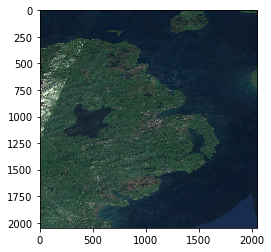

In [42]:
coast = skimage.io.imread('./data/coast.jpg')
plt.imshow(coast)

We have actually imported this image as a numpy array. In fact, this is actually plotting using the same technique as our Inflammation numpy tutorial - it's a graph of cells, where each cell has colour values. Pixels you might say...

In [43]:
coast[0, 0, :]

array([14, 33, 48], dtype=uint8)

First, we soften some of the noise using a Gaussian blur.

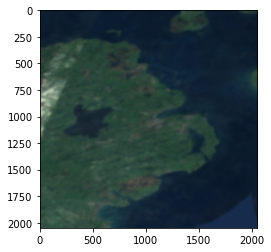

In [44]:
from skimage import filters

smooth = filters.gaussian(coast, sigma=10, multichannel=True)
plt.imshow(smooth)

As this is a 3d matrix, as far as numpy is concerned, we can extract a single colour channel using a slice. Here is the green one (think RGB - G has index 1).

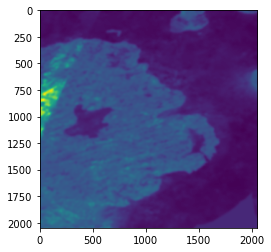

In [45]:
plt.imshow(smooth[:,:,1])

A simple, coarse way to trim all the non-sea (land, as it's known) is to pick everything that is more than a little green. Here we set anything with more than 0.2 in the green column to black.

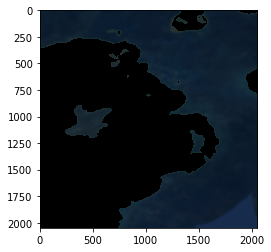

In [46]:
smooth[smooth[:,:,1] > 0.2] = [0, 0, 0]
plt.imshow(smooth)

Next, we go one step further, by selecting _just_ the blue channel and trimming (setting to -1) everything that is outside of an emperical or heuristic (i.e. guessed or made up) window.

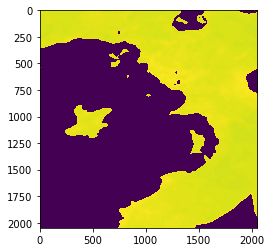

In [47]:
sea = smooth[:,:,2].copy()
sea[(sea < 0.1) | (sea > 0.25)] = -1
plt.imshow(sea)

OK, so we have some sea now - we know where it is. Now lets split it into layers of deep and shallow. To do this, we use a basic image segmentation technique, which is no more than numpy's `histogram` function. This puts all of our pixels into labeled "bins" (or layers, in our 2d image case).

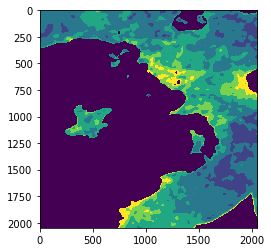

In [48]:
# This number is our own choice of sea-depth layers
bins = 5

# We split up the sea into a set of bins
hist, bin_edges = np.histogram(
    sea,
    bins=bins,
    range=(sea[sea > 0].min(), sea.max())
)

# And create a new array called layers that matches each pixel to a depth layer: shallow...deep
last_edge = bin_edges[0]
layers = np.zeros(sea.shape, dtype=int) - 1
for n, next_edge in enumerate(bin_edges[1:]):
    layers[(sea > last_edge) & (sea <= next_edge)] = n
    last_edge = next_edge
plt.imshow(layers)

Now we can see the variety of layers - with as many colours as our `bins` variable.

As an aside for later - let's calculate what fraction of the visible sea each layer takes up.

In [49]:
segment_frequencies = np.bincount(layers[layers >= 0].flatten())
nonzero_pixels = sum(segment_frequencies)
segment_fraction = segment_frequencies / nonzero_pixels
segment_fraction

array([0.1091253 , 0.42614025, 0.32343668, 0.10812775, 0.03317001])

## Back to charts

Does this match up with our map?

In [50]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

layer_bounds = [[53.81683262680313, -6.78096405771856],[55.45928868149063, -5.14400116709356]]

tile = folium.raster_layers.ImageOverlay(
    name='coast',
    image=layers,
    bounds=layer_bounds,
    attr=attr,
    opacity=0.6,
    zindex=1
).add_to(fmap)

for cluster in clusters.values():
    cluster.add_to(fmap)
    
LayerControl().add_to(fmap)
fmap

Close enough, given all the approximations. Next...

## Labelling our wrecks

We need to create a function that we can pass a wreck to, and it will give its corresponding layer.

We have a couple of convenient tools in scipy and numpy:
* linspace : this creates an array linearly spread from one limit to another
* meshgrid : this turns a set of horizontal and vertical axis ticks into a list of all the points in the corresponding grid
* inter2p : this takes a series of axis ticks and function values at every grid point, and gives a callable function taking any coordinate whatsoever and returning the linearly-interpolated function value

In [51]:
import scipy

layer_x = np.linspace(layer_bounds[0][1], layer_bounds[1][1], len(layers[0]))
layer_y = np.linspace(layer_bounds[1][0], layer_bounds[0][0], len(layers))
layers_flat = layers.copy().flatten()
segment = scipy.interpolate.interp2d(layer_x, layer_y, layers)

We can plot this interpolated function to see what it looks like in 3D.

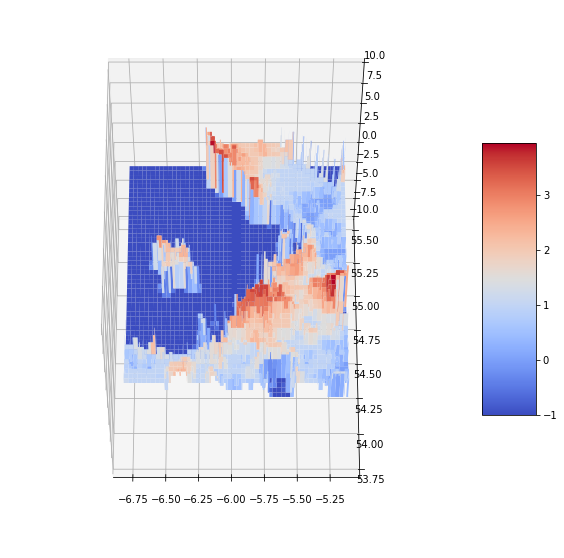

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_zlim(-10, 10)
ax.view_init(60, -90)

X, Y = np.meshgrid(layer_x, layer_y)
surf = ax.plot_surface(X, Y, segment(layer_x, layer_y), cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Finally, to use our interpolated labelling function, we turn back to our old dataframe method, `apply`.

In [53]:
def point_to_segment(wreck):
    interp = segment(wreck.geometry.x, wreck.geometry.y)
    wreck['segment'] = int(round(interp[0]))
    return wreck
gdf = gdf.apply(point_to_segment, axis=1)
gdf.head()

,Name,Date_lost,Type,Cargo,Depth,Position_q,Condition,Ref,Status,Notes,...,Nation,How_lost,Legislatio,Notes_1,Origin,Where_lost,geometry,century,label,segment
0,Ailsa,26/02/1892,Steamship (British),General,1-5m,Reasonable,"Badly broken up, part of wreck is onshore","UKHO, IRW, CMA",LIVE,None,...,None,None,None,None,None,None,POINT (-5.738216765202008 54.85250042372012),18,4,-1
1,(ex HMS) Alastor,11/03/1946,Corvette / Motor yacht (British),None,10-23m,Accurate,Llargely intact with upright funnel. Wooden de...,"UKHO, IRW, CMA",LIVE,None,...,None,None,None,None,None,None,POINT (-5.629383430791251 54.45155042371992),19,-1,-1
2,Albia (poss.),28/09/1929,Spanish tramp steamer,Copper ore,10m,Approximate,"5m high, upright.","IRW, UKHO, CMA",LIVE,None,...,None,None,None,None,None,None,POINT (-5.741317099083887 54.94993342278837),19,-1,2
3,Alcedo,??/01/1892,Steam coaster,Coal,7m,Approximate,"2.5m high, badly broken up","IRW, CMA",LIVE,None,...,None,None,None,None,None,None,POINT (-5.696200098805885 54.81548342367984),None,-1,-1
4,Alder,None,None,None,-3m,Approximate,None,UKHO,LIFT,Wreck removed 1938,...,None,None,None,None,None,None,POINT (-6.098500100507256 54.05321709066201),None,-1,-1


## Displaying this detail

Lets work out which segments we actually have wrecks in (we don't want to add more layers than necessary)

In [54]:
segments_active = set(gdf.loc[:, 'segment']) - {-1}
segments_active

{0, 1, 2, 3, 4}

Now lets create a copy of our dataframe for further manipulation.

In [55]:
# ldf = gdf.copy()
ldf = gdf[gdf['century'] == '19'].copy()

Much as above, we can run through our wrecks, but we use a handy colourmap library to give us shades indicating our depth layer.

In [56]:
import branca.colormap as cm

In [57]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

mid = min(segments_active) + (max(segments_active) - min(segments_active)) / 2
colormap = cm.LinearColormap(
    ['red', 'yellow', 'green'],
    index=[min(segments_active), mid, max(segments_active)]
)

def add(wreck):
    pt = wreck.geometry
    
    if wreck['segment'] > -1:
        colour = colormap(wreck['segment'])
        folium.CircleMarker(
            [pt.y, pt.x],
            popup=wreck['Name'],
            fill_color=colour,
            color=colour
        ).add_to(fmap)
        
    return wreck

ldf = ldf.apply(add, axis=1)

LayerControl().add_to(fmap)
fmap

So that's nice, but it still doesn't answer our question - is there a correlation between depth and wreck frequency? Time to do some stats...

In [58]:
segment_table = ldf[ldf['segment'] > -1].groupby('segment').agg('count')

total_segmented = segment_table['Name'].sum()

def percentage(row):
    row['Count'] = row['Name']
    row['Blue Depth'] = bin_edges[row.name]
    row['% wrecks'] = 100 * row['Name'] / total_segmented
    row['% area'] = 100 * segment_fraction[row.name]
    row['Wreck Frequency'] = row['% wrecks'] / row['% area']
    return row

segment_table = segment_table.apply(percentage, axis=1)
segment_table = segment_table[['Count', 'Blue Depth', '% wrecks', '% area', 'Wreck Frequency']]
segment_table

,Count,Blue Depth,% wrecks,% area,Wreck Frequency
segment,,,,,
0,15.0,0.154842,11.111111,10.912530,1.018198
1,58.0,0.173873,42.962963,42.614025,1.008188
2,40.0,0.192903,29.629630,32.343668,0.916087
3,16.0,0.211934,11.851852,10.812775,1.096097
4,6.0,0.230964,4.444444,3.317001,1.339898


So not hugely, but around a third higher for the shallow (mostly coastal) areas. Not a huge gap, but oh well... it may be worth trying for other centuries though...

In any case, let's put it all together and see what our shipwreck map now looks like.

In [59]:
fmap = folium.Map(location=(middle.y, middle.x), zoom_start=7)

def add(wreck):
    pt = wreck.geometry
    
    if wreck['segment'] > -1:
        colour = colormap(wreck['segment'])
        folium.CircleMarker(
            [pt.y, pt.x],
            popup="%s (%.2lf, %.2lf)" % (wreck['Name'], wreck.geometry.y, wreck.geometry.x),
            fill_color=colour,
            fill_opacity=1,
            radius=8,
            color=colour
        ).add_to(fmap)
        
    return wreck

ldf.apply(add, axis=1)

tile = folium.raster_layers.ImageOverlay(
    name='coast',
    image=layers,
    bounds=layer_bounds,
    attr=attr,
    opacity=0.9,
    zindex=1
).add_to(fmap)

LayerControl().add_to(fmap)
fmap

# Exercise

Try rerunning the above for different centuries. Do all centuries (with data) have similar results? Does this tell you something about seafaring over time? Are all century datasets equally valid for analysis?

# Answers

In [ ]:
import dateutil

def get_century(dt):
    date = None
    
    if dt:
        try:
            date = dateutil.parser.parse(dt)
        except ValueError:
            pass
        else:
            if date and date.year:
                date = str(date.year)[0:2]
            else:
                date = None

    return date